# Initialization

In [3]:
!nvidia-smi

Sat Mar 20 16:19:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download Kaggle Data

In [ ]:
# Download data and move to Google Drive
!pip install -q kaggle
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c shopee-product-matching
!mv shopee-product-matching.zip ./drive/MyDrive/data/

In [42]:
# Copy from Google Drive and unzip
!cp ./drive/MyDrive/data/shopee-product-matching.zip ./
!unzip -q shopee-product-matching.zip
!rm shopee-product-matching.zip

## Import Packages

In [85]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0
from cuml.neighbors import NearestNeighbors
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.cluster import DBSCAN
import gc
import pandas as pd
import numpy as np
import cudf, cuml, cupy
import pickle

In [44]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
SEED = 100
BATCH_SIZE =32
CHUNK_SIZE = 4096
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
LIMIT = 2.0
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

if physical_devices:
  tf.config.experimental.set_virtual_device_configuration(
      physical_devices[0],
      [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*LIMIT)])
  print('TensorFlow usage is restricted to max %iGB GPU RAM'%LIMIT)

Num GPUs: 1
TensorFlow usage is restricted to max 2GB GPU RAM


# Process Data

In [8]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
#     image /= 255  # normalize to [0,1] rangeI'm not a 
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def augmentation(ds):
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
      layers.experimental.preprocessing.RandomRotation(0.3),
      layers.experimental.preprocessing.RandomTranslation(
          height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
      layers.experimental.preprocessing.RandomZoom(0.2, 0.2),
    ])
    
    # Batch all datasets
    ds = ds.batch(BATCH_SIZE)

    # Use data augmentation only on the training set
    ds = ds.map(lambda x: data_augmentation(x))

    # Prefecting on all datasets
    return ds.prefetch(1)

def prepare_data(df, augment=False):
    # Load images
    path_ds = tf.data.Dataset.from_tensor_slices(df['image_paths'])
    image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

    if augment:
        ds = augmentation(image_ds)
    else:
        ds = image_ds.batch(BATCH_SIZE).prefetch(1)
    
    return ds

In [47]:
load_dir = os.getcwd()
# Load and process images
df_train = pd.read_csv(load_dir + '/train.csv')
df_train['image_paths'] = load_dir + '/train_images/' + df_train['image'] 

# Ground truth
tmp = df_train.groupby('label_group').posting_id.agg('unique').to_dict()
df_train['target'] = df_train.label_group.map(tmp)

# Duplicate train set for runtime testing 
# df_train = pd.concat([df_train, df_train], ignore_index=True)
train_ds = prepare_data(df_train, augment=False)

# Embeddings

In [48]:
def find_similar_items(embeddings, threshold, fine_tune=False):
  """
  Using Nearest Neighbors to figure out similar items
  """
  knn = NearestNeighbors(n_neighbors=50)
  knn.fit(embeddings)

  num_chunk = round(embeddings.shape[0] / CHUNK_SIZE)
  item_index = []
  for i in range(num_chunk+1):
    start_idx = i * CHUNK_SIZE                  
    end_idx = min((i + 1) * CHUNK_SIZE, embeddings.shape[0])
    if not fine_tune:
      print('Chunk', start_idx, 'to', end_idx) 

    dist, idx = knn.kneighbors(embeddings[start_idx:end_idx, :])
    counts = (dist < threshold).sum(axis=1)
    chunk_index = [idx[i, :counts[i]].tolist() for i in range(end_idx - start_idx)]
    item_index += chunk_index

  return item_index

## Image Embedding

In [86]:
# Image embedding
effnet = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=None)
embeddings_image = effnet.predict(train_ds, verbose=1)

del effnet
_ = gc.collect()

1071/1071 [==============================] - 55s 50ms/step


In [107]:
  knn = NearestNeighbors(n_neighbors=50)
  knn.fit(embeddings_image)
  dist, idx = knn.kneighbors(embeddings_image)

In [108]:
plt.figure(figsize=(10, 10))
for i, image_path, in enumerate(df_train['image_paths'][:9]):
    plt.subplot(3, 3, i + 1)
    image = tf.io.read_file(image_path)
    image = preprocess_image(image)
    plt.imshow(image)
plt.show()

(34250, 50)

In [113]:
df_train[df_train.f1 < 0.5] 

,posting_id,image,image_phash,title,label_group,image_paths,target,matches,f1
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,/content/train_images/00117e4fc239b1b641ff0834...,"[train_2406599165, train_3342059966]",train_1744956981 train_2043094887 train_150810...,0.222222
22,train_1396146683,0035b8fc42955c0fa2301b68e2ffe861.jpg,d5c0caa0aeb3b23e,CHOCO BALL LAGIE COKLAT Lagie Grosir Cokelat L...,4240123481,/content/train_images/0035b8fc42955c0fa2301b68...,"[train_1396146683, train_2843292969, train_422...",train_2382901010 train_3433558650 train_139614...,0.285714
24,train_1872347548,003906c6c6bba4cde15e5e854dba8f6d.jpg,f3e18c5ea14493e3,Stand Hanger Multifungsi - Tiang Gantungan Baj...,4044205497,/content/train_images/003906c6c6bba4cde15e5e85...,"[train_1872347548, train_998519723, train_1760...",train_1872347548,0.250000
26,train_2905529497,003c7129aef72ad3ae8af64eac5bfd29.jpg,ce4e2d3570721ab5,Masker Medis 3ply Earloop (50pcs) - Masker 3pl...,2034299767,/content/train_images/003c7129aef72ad3ae8af64e...,"[train_2905529497, train_869563964]",train_2842980767 train_3020446014 train_290552...,0.400000
38,train_4146813717,005a507afe7092537e4c6243c4e0d790.jpg,e69999668c663399,Soti Antiseptic Spray 100ml,3816307840,/content/train_images/005a507afe7092537e4c6243...,"[train_4146813717, train_2095066661, train_257...",train_3615094030 train_2672786546 train_365410...,0.150000
...,...,...,...,...,...,...,...,...,...
34215,train_2079568096,ffb355e7707313dac74d60b5d13d2d4e.jpg,f841cf6bcc4a850f,EPSON 664 - TINTA BOTOL ORIGINAL EPSON 70ML UN...,1518626050,/content/train_images/ffb355e7707313dac74d60b5...,"[train_829584474, train_2079568096]",train_2079568096 train_3392119229 train_235202...,0.400000
34218,train_3349791994,ffb9b59c7669c781847fba7499bd7699.jpg,f4ce05c51f71705a,LACHEL VITAMIN C LACHEL VIT C GLUTA FROZEN COL...,1911010635,/content/train_images/ffb9b59c7669c781847fba74...,"[train_150841277, train_4099484977, train_2689...",train_3349791994,0.285714
34221,train_2918683619,ffbf2266ff17f4bc336002a00d82b647.jpg,afde42252f25c992,Sticker Star Wall Glow In The Dark | Stiker Bi...,3251156563,/content/train_images/ffbf2266ff17f4bc336002a0...,"[train_1774249647, train_2918683619]",train_2486599982 train_1020260882 train_295591...,0.200000
34235,train_3668806308,ffdd054398884b04bdab9e41d30c7fb2.jpg,9ba6cc38a4a792f1,MAYCREATE MOISTURIZING SPRAY 150ML(1KG 6PCS) ...,1141798720,/content/train_images/ffdd054398884b04bdab9e41...,"[train_3497907844, train_4175229751, train_293...",train_1799291694 train_112182868 train_3668806...,0.210526


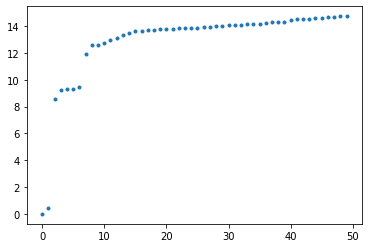

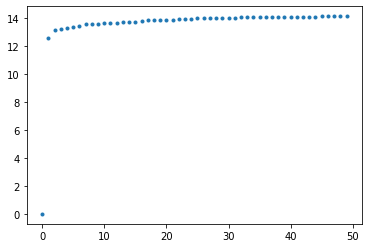

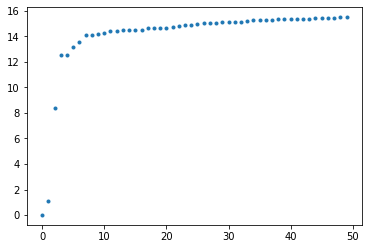

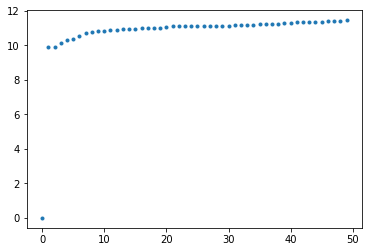

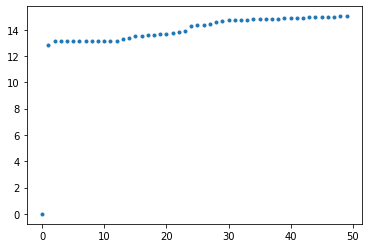

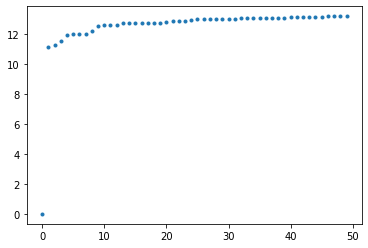

In [106]:
import matplotlib.pyplot as plt
for i in range(179, 185):
  plt.scatter(np.arange(0,50), dist[i], marker='.')
  plt.show()

In [87]:
# Similiar images
image_index = find_similar_items(embeddings_image, 6.8)

Chunk 0 to 4096
Chunk 4096 to 8192
Chunk 8192 to 12288
Chunk 12288 to 16384
Chunk 16384 to 20480
Chunk 20480 to 24576
Chunk 24576 to 28672
Chunk 28672 to 32768
Chunk 32768 to 34250


## Text Embedding

In [88]:
# Text embedding
cudf_train = cudf.DataFrame(df_train)
sentences = cudf_train.title
vectorizer = TfidfVectorizer(binary=True, max_features=15000)
embeddings_text = vectorizer.fit_transform(sentences).toarray()

del sentences, vectorizer
_ = gc.collect()

In [89]:
# Similar texts
text_index = find_similar_items(embeddings_text, 0.8)

Chunk 0 to 4096
Chunk 4096 to 8192
Chunk 8192 to 12288
Chunk 12288 to 16384
Chunk 16384 to 20480
Chunk 20480 to 24576
Chunk 24576 to 28672
Chunk 28672 to 32768
Chunk 32768 to 34250


# Evaluation

In [90]:
def row_wise_f1_score(y_true, y_pred):

    y_true = y_true.apply(lambda x: set(x))
    y_pred = y_pred.apply(lambda x: set(x.split()))

    tp = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    fp = y_pred.apply(lambda x: len(x)).values - tp
    fn = y_true.apply(lambda x: len(x)).values - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * ((precision * recall) / (precision + recall))
    return f1

def evaluation(df_data, image_index, text_index):
  df_data['matches'] = [
      ' '.join(
          set(df_data['posting_id'][text].tolist() +
              df_data['posting_id'][image].tolist()))
      for text, image in zip(text_index, image_index)
  ]

  df_data['f1'] = row_wise_f1_score(df_data['target'], df_data['matches'])
  return df_data['f1'].mean()

print('f1-score:', evaluation(df_train, image_index, text_index))

f1-score: 0.7352807029236548


## Fine-tuning

In [91]:
def parameter_tuning(df_data, embeddings_image, embeddings_text, 
                     threshold_image, threshold_text):
  
    image_index = find_similar_items(embeddings_image, threshold_image, fine_tune=True)
    text_index = find_similar_items(embeddings_text, threshold_text, fine_tune=True)
    f1_score = evaluation(df_data, image_index, text_index)
    print('threshold_image: {}, threshold_text: {}, f1-score: {}'.format(round(threshold_image, 2), round(threshold_text, 2), round(f1_score, 4)))

    return f1_score

In [94]:
results = {}
for i in np.arange(6.5, 7, .1):
  for j in np.arange(0.8, 0.88, 0.01):
    f1 = parameter_tuning(df_train, embeddings_image, embeddings_text, i, j)
    results[(round(i,2), round(j,2))] = f1

print('The best thresholds are {}, yield a f1-score of {}'.format(max(results, key=results.get), max(results.values())))

threshold_image: 6.5, threshold_text: 0.8, f1-score: 0.7364
threshold_image: 6.5, threshold_text: 0.81, f1-score: 0.7372
threshold_image: 6.5, threshold_text: 0.82, f1-score: 0.7377
threshold_image: 6.5, threshold_text: 0.83, f1-score: 0.7386
threshold_image: 6.5, threshold_text: 0.84, f1-score: 0.739
threshold_image: 6.5, threshold_text: 0.85, f1-score: 0.7398
threshold_image: 6.5, threshold_text: 0.86, f1-score: 0.7402
threshold_image: 6.5, threshold_text: 0.87, f1-score: 0.7397
threshold_image: 6.6, threshold_text: 0.8, f1-score: 0.736
threshold_image: 6.6, threshold_text: 0.81, f1-score: 0.7367
threshold_image: 6.6, threshold_text: 0.82, f1-score: 0.7372
threshold_image: 6.6, threshold_text: 0.83, f1-score: 0.7382
threshold_image: 6.6, threshold_text: 0.84, f1-score: 0.7385
threshold_image: 6.6, threshold_text: 0.85, f1-score: 0.7393
threshold_image: 6.6, threshold_text: 0.86, f1-score: 0.7396
threshold_image: 6.6, threshold_text: 0.87, f1-score: 0.7391
threshold_image: 6.7, thresh